In [ ]:
# Install keras-retinanet which is a wrapper around Keras that offers helper functions to do transfer learning on objet detection models.
!git clone https://github.com/fizyr/keras-retinanet.git
!pip install keras-retinanet --force-reinstall --upgrade

# Download pre-trained weights on COCO dataset
!wget 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

# Compile Cython files required
!cd keras-retinanet/ && python setup.py build_ext --inplace && cd ..

# Download dataset
!wget 'https://data.4tu.nl/repository/uuid:8b8ba63a-1010-4de7-a7fb-6f9e3baf128e/BAG?download=true'
!unzip 'BAG?download=true'

# Make sure Pillow is up-to-date
!pip install Pillow --force-reinstall --upgrade

# Download sample image
!wget 'https://c1.staticflickr.com/9/8317/8017170672_820af3135a_b.jpg'
!mv '8017170672_820af3135a_b.jpg' 'people.jpg'

In [ ]:
!cd keras-retinanet/ && python setup.py build_ext --inplace && cd ..

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


## IMPORTANT!
## Please restart the runtime (if running on Colab) after running the cell above to reload latest packages.
## If running this colab notebook, please make sure the the runtime type is set to GPU.

In [ ]:
# Mount Drive to store model weights among other things
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# keras-retinanet requires tensorflow 1.x
%tensorflow_version 1.x

import glob
from pathlib import Path

import shutil
import os
import random
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = Path('dataset/data/4TUDatasetAnonymised/')

In [ ]:
# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# other modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

Using TensorFlow backend.


## Testing a pre-trained resnet50 model on a sample image

For this task, I chose to train on a residual neural network (resnet). The network is present in many variants. I chose resnet50 (which is composed of 50 layers) because it is faster to train than deeper versions of it. The model is composed of two sub-networks: a regression sub-network which predicts the coordinates of the bounding boxes and a classification sub-network which assigns each box to a class.

In [ ]:
# Load model initializing weights with pre-trained weights on CoCo dataset.
model_path = os.path.join('.', 'resnet50_coco_best_v2.1.0.h5')
pretrained_model = models.load_model(model_path, backbone_name='resnet50')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Displays layers of the pretrained model
pretrained_model.summary()


processing time:  5.71380090713501


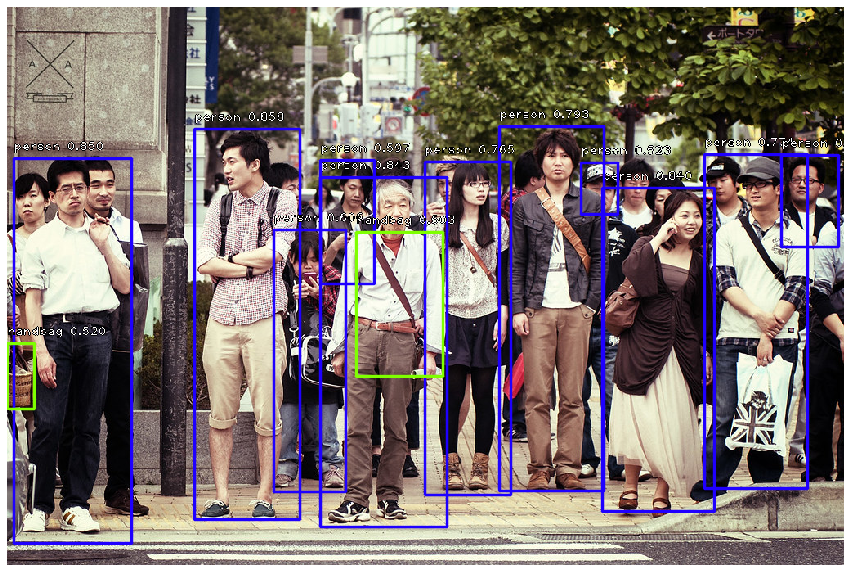

In [ ]:
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

from io import BytesIO
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def read_image_bgr(path):
    """ Read an image in BGR format.

    Args
        path: Path to the image.
    """
    image = np.asarray(Image.open(path).convert('RGB'))
    return image[:, :, ::-1].copy()


# load image
image = read_image_bgr('people.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = pretrained_model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Preparing the data

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split


def xml_to_csv(path, train_ratio=0.8):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        xml_path = Path(xml_file)
        # Decide whether this picture should belong to the training or validation set
        is_train = True if random.uniform(0, 1) < train_ratio else False

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (f'{xml_path.stem}.jpg',
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text),
                     member[0].text,
                     is_train
                    )

            xml_list.append(value)
    column_name = ['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'is_train']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


DATA_DIR = Path('data/4TUDatasetAnonymised/')
df = xml_to_csv(str(DATA_DIR), train_ratio=0.8)

# Split into train and validation
df_train, df_val = df[df['is_train'] == True], df[df['is_train'] == False]
# Drop the is_train column
df_train = df_train.drop('is_train', axis=1)
df_val = df_val.drop('is_train', axis=1)

# Generate CSV files for annotations
TRAIN_PATH = DATA_DIR / Path('train_annotations.csv')
VAL_PATH = DATA_DIR / Path('val_annotations.csv')
df_train.to_csv(TRAIN_PATH, header=False, index=False)
df_val.to_csv(VAL_PATH, header=False, index=False)

# Generate CSV file for class to id mapping
CLASSES_PATH = DATA_DIR / Path('class_map.csv')
df_classes = pd.DataFrame({'name':['MR', 'NC', 'WF', 'TR'], 'id':[0, 1, 2, 3]})
df_classes.to_csv(CLASSES_PATH, header=False, index=False)

In [ ]:
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.transform import random_transform_generator

def create_generators(train_annotations, validation_annotations, classes_path, preprocess_image, config=None, batch_size=16):
    common_args = {
        'batch_size'       : batch_size,
        'config'           : config,  # config, default to None
        'image_min_side'   : 800,   # Smallest size to rescale min side to
        'image_max_side'   : 1333,   # Smallest size to rescale max side to
        'preprocess_image' : preprocess_image,
    }

    # create random transform generator for augmenting training data
    transform_generator = random_transform_generator(
        min_rotation=-0.1,
        max_rotation=0.1,
        min_translation=(-0.1, -0.1),
        max_translation=(0.1, 0.1),
        min_shear=-0.1,
        max_shear=0.1,
        min_scaling=(0.9, 0.9),
        max_scaling=(1.1, 1.1),
        flip_x_chance=0.5,
        flip_y_chance=0.5,
    )

    train_generator = CSVGenerator(
        train_annotations,
        classes_path,
        transform_generator=transform_generator,
        **common_args
    )

    validation_generator = CSVGenerator(
        validation_annotations,
        classes_path,
        shuffle_groups=False,
        **common_args
    )

    return train_generator, validation_generator


In [ ]:
def setup_gpu(gpu_id=0):
  # Activate gpu for tensorflow
  import os
  if gpu_id == 'cpu' or gpu_id == -1:
      os.environ['CUDA_VISIBLE_DEVICES'] = ""
      return

  os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  tf.keras.backend.set_session(tf.Session(config=config))

## Transfer learning: Training an initial model

In [ ]:
import keras
from tensorflow.python.keras import losses
import keras_retinanet.losses
import keras_retinanet.models
import tensorflow as tf
from keras_retinanet.utils.model import freeze as freeze_model
from keras.callbacks import ModelCheckpoint

# Activate GPU
setup_gpu(0)

# Create new model with resnet50 backbone.
backbone = keras_retinanet.models.backbone('resnet50')
# Set up 4 classes in the output layer and freeze the model to speed training
model = backbone.retinanet(num_classes=4, modifier=freeze_model)

# Load weights into our new model from pre-trained weights.
# If weights trained are available, load them directly. Otherwise, load weights pretrained on COCO dataset.

if os.path.isfile('model-checkpoint-180.hdf5'):
  print('file found')
  model.load_weights('model-checkpoint-180.hdf5', by_name=True, skip_mismatch=True)
else:
  model.load_weights('resnet50_coco_best_v2.1.0.h5', by_name=True, skip_mismatch=True)

# Set paths in which to save weights
filepath="drive/My Drive/model-checkpoint-{epoch:02d}.hdf5"
# Define callback to save model after each 10 epoch (In case Colab crashes)
checkpoint = ModelCheckpoint(filepath, verbose=1, period=10, save_weights_only=True, save_best_only=True)

# Compile model. Losses are defined for each subnetwork
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001),
    metrics=['accuracy'],
)

file found


In [ ]:
model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_13[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________

The model summary shows that the architecture is composed of two submodels: classification and regression model.

This latter predicts the position of the bouding boxes, and the classification model classifies the class represented by each bounding box.

In [ ]:
train_generator, validation_generator = create_generators(
    TRAIN_PATH,
    VAL_PATH,
    CLASSES_PATH,
    backbone.preprocess_image)

history = model.fit_generator(
            generator=train_generator,
            epochs=1, # Setting to 1 epoch to show state of current model. Originally trained on 180 epochs (took 10 hours).
            steps_per_epoch=1, # Setting to 1 for demonstration purposes ...
            verbose=1,
            validation_data=validation_generator,
            callbacks=[checkpoint],
            initial_epoch=0)

Epoch 1/1
1/1 [==============================] - 32s 32s/step - loss: 1.2305 - regression_loss: 1.0184 - classification_loss: 0.2121 - regression_accuracy: 0.3217 - classification_accuracy: 0.9465 - val_loss: 1.1104 - val_regression_loss: 0.9391 - val_classification_loss: 0.1989 - val_regression_accuracy: 0.2608 - val_classification_accuracy: 0.9529


As we can see from the results above, the classification accuracy (how well the classification sub-network classifies each bounding boxes) reached 95% on the validation set. Whereas the regression accuracy is just 27.63%. This shows that our model classifies well when it detects boxes but misses many boxes.

In [ ]:
# model is a training model. Need to convert to inference model to make predictions.
inference_model = models.convert_model(model)

tracking <tf.Variable 'Variable_20:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_21:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_22:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_23:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_24:0' shape=(9, 4) dtype=float32> anchors


## Testing

processing time:  1.8365225791931152


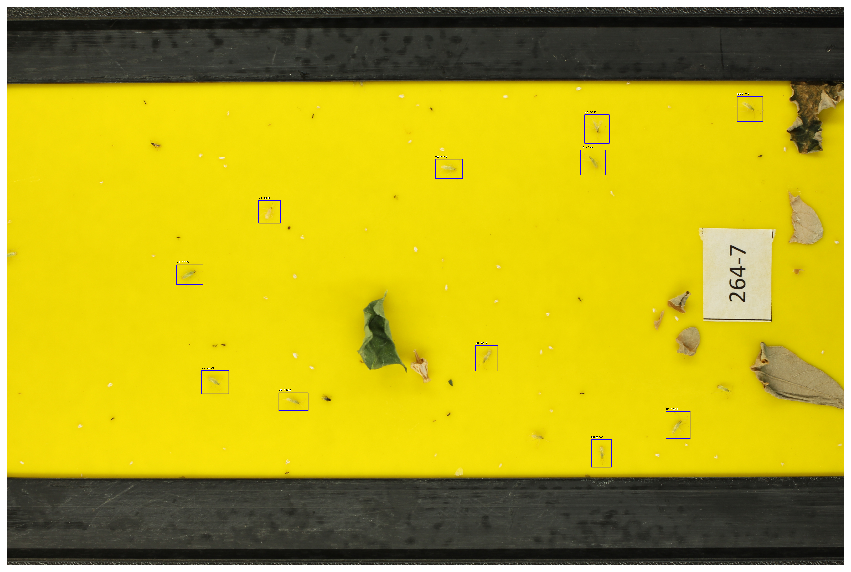

In [ ]:
# Assign number to each one of the 4 classes.
labels_to_names = {0: 'MR', 1: 'NC', 2: 'WF', 3: 'TR'}

# load image
image = read_image_bgr(DATA_DIR / Path('1001.jpg'))

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = inference_model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break

    color = label_color(label)
    b = box.astype(int)
    draw_box(draw, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Conclusion and remarks

Although the model trained for 180 epochs (which took 10 hours to complete), the regression accuracy was still low. After running the model on a few images, it was interesting to see that the prediction of the boundary boxes where not as bad as the accuracy shows. After researching online, I found that one explanation for that is that the small size of the objects might influence on the value of the IoU (intersection over union) metric used to calculate the accuracy of the prediction.

Because of the long time it takes to train, I wasn't able to do many iterations and fix these flaws. However, the next steps would be to test other alternatives such as cropping pictures and enlarging them so that the insects take a bigger place in the image. Another potential solution is to use keras-retinanet's capabilities to optimize for smaller objects which can be found here: [link](https://github.com/fizyr/keras-retinanet#anchor-optimization)

# Evalutation
We use https://github.com/rafaelpadilla/Object-Detection-Metrics to calculate mAP metrics on our model. The cells below create the data needed for the mAP to be calculated


In [ ]:
# Run prediction on all images in validation set
labels_to_names = {0: 'MR', 1: 'NC', 2: 'WF', 3: 'TR'}

df_val_truth = []
filename_to_truth_df = {}
filename_to_pred_df = {}
# load image
for i, filename in enumerate(df_val.filename.unique()):
  df_file = df_val[df_val.filename == filename]
  image = read_image_bgr(DATA_DIR / Path(f'{filename}'))
  filename_to_truth_df[filename] = []
  for _, row in df_file.iterrows():
    ground_truth = (row['class'], row.xmin, row.ymin, row.xmax, row.ymax)
    filename_to_truth_df[filename].append(ground_truth)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  boxes, scores, labels = inference_model.predict_on_batch(np.expand_dims(image, axis=0))

  # correct for image scale
  boxes /= scale
  found = False
  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < 0.5:
          break

      found = True
      pred_result = (labels_to_names[label], score, box[0], box[1], box[2], box[3])
      filename_to_pred_df[row.filename] = filename_to_pred_df.get(row.filename, [])
      filename_to_pred_df[row.filename].append(pred_result)

  print(f'Image {i} processed.')

  for filename, truths in filename_to_truth_df.items():
    filename_to_truth_df[filename] = pd.DataFrame(truths)

  if not found:
    filename_to_pred_df[filename] = []

  for filename, preds in filename_to_pred_df.items():
    filename_to_pred_df[filename] = pd.DataFrame(preds)

In [ ]:
# Download library to calculate mAP
!git clone 'https://github.com/rafaelpadilla/Object-Detection-Metrics'

# Empty samples folder
!rm Object-Detection-Metrics/detections/*
!rm Object-Detection-Metrics/groundtruths/*

In [ ]:
# Store our validation dataset in csv

truth_path = Path('Object-Detection-Metrics/groundtruths/')
pred_path = Path('Object-Detection-Metrics/detections/')

for filename, truths in filename_to_truth_df.items():
  p = Path(filename)
  filename_to_truth_df[filename].to_csv(truth_path / Path(f'{p.stem}.txt'), header=False, index=False, sep=' ')

for filename, preds in filename_to_pred_df.items():
  p = Path(filename)
  filename_to_pred_df[filename].to_csv(pred_path / Path(f'{p.stem}.txt'), header=False, index=False, sep=' ')

In [ ]:
# Calculate the mean average precision (mAP) for our object-detection model
%matplotlib inline
!python Object-Detection-Metrics/pascalvoc.py

<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
<Figure size 640x480 with 1 Axes>
AP: 52.31% (MR)
AP: 71.71% (NC)
AP: 0.00% (WF)
mAP: 41.34%


# Debugging

After running a debugging script, it made it more clear what the mistake was. I displayed the annotations on the images from the dataset. Annotations are colored in green when there are anchors available and colored in red when there are no anchors available. If an annotation doesn't have anchors available, it means it won't contribute to training.
The following image shows how WF didn't have an anchor available:


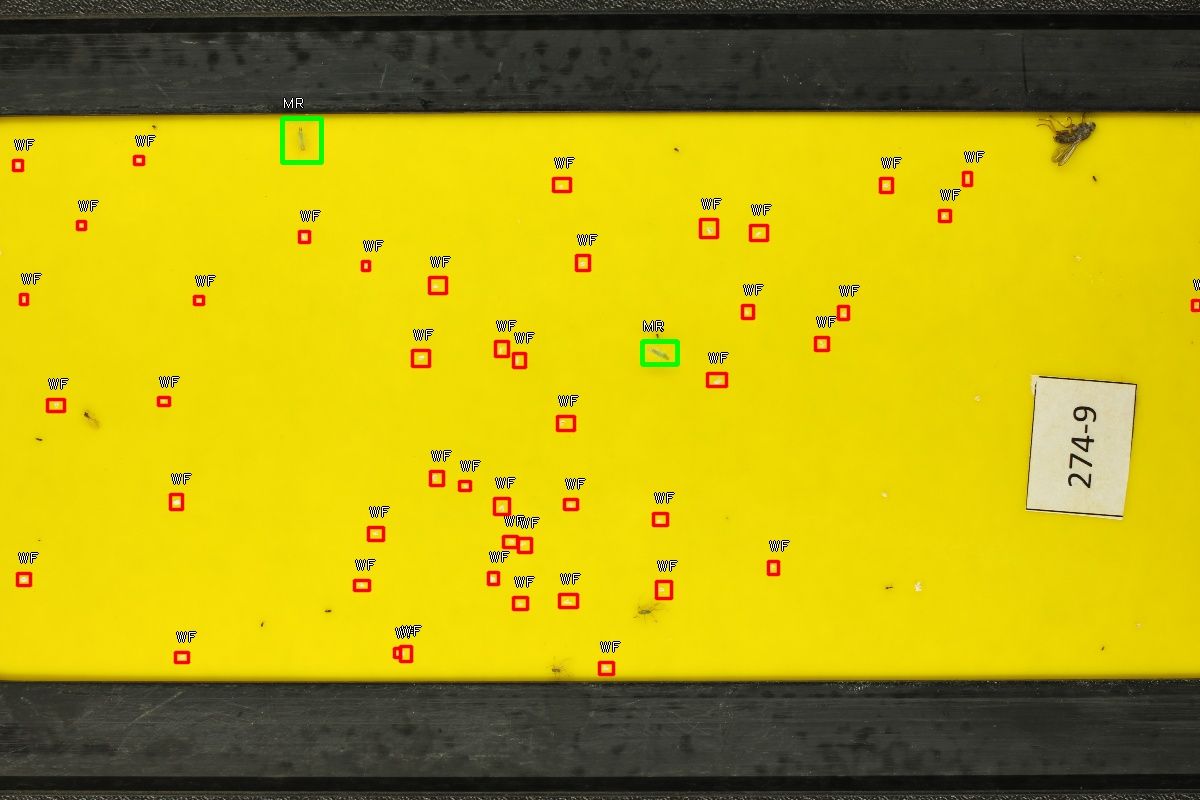

In [ ]:
from IPython.display import Image
Image('1000_debug.jpg')

The small bounding boxes (typically WF) were not detected which might explain why the accuracy was high. WFs were basically not taken into account during training.

# Optimizing anchor points


In [ ]:
!git clone 'https://github.com/martinzlocha/anchor-optimization.git'

!cd anchor-optimization && pip install . && cd ..
!cd anchor-optimization && python setup.py build_ext --inplace && cd ..

!cd anchor-optimization && python optimize_anchors.py '../data/4TUDatasetAnonymised/train_annotations.csv'

fatal: destination path 'anchor-optimization' already exists and is not an empty directory.
Processing /content/anchor-optimization
  Created wheel for anchor-optimization: filename=anchor_optimization-0.0.1-cp36-cp36m-linux_x86_64.whl size=77446 sha256=e9daea0b4f2add4efcd846070167ea7ec2f027a75c4c5f2db7002e4ce618a4a4
  Stored in directory: /root/.cache/pip/wheels/52/cb/a7/aa0c417c0cb603e0a8bdb2887ffff23cf50a689d2113eb267e
Successfully built anchor-optimization
  Found existing installation: anchor-optimization 0.0.1
    Uninstalling anchor-optimization-0.0.1:
      Successfully uninstalled anchor-optimization-0.0.1
running build_ext
skipping 'compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> 
Using TensorFlow backend.
Loading object dimensions.
Optimising anchors.
Current best anchor configuration
Ratios: [0.36, 1.0, 2.78]
Scales: [0.656, 0.929, 1.094]
Number of labels that don't have any matching anch

As we can notice from the output above, the final best anchor configuration is:
- Ratios: [0.662, 1.0, 1.509]
- Scales: [0.4, 0.476, 0.582]

In [ ]:
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters

# Create config.ini file
config_str = ("[anchor_parameters]\n"
"sizes   = 32 64 128 256 512\n"
"strides = 8 16 32 64 128\n"
"ratios  = 0.662 1.0 1.51\n"
"scales  = 0.4 0.476 0.582\n")

with open("config.ini", "w") as config_file:
    config_file.write(config_str)

config = read_config_file('config.ini')
anchor_params = parse_anchor_parameters(config)

In this dataset, using the default anchor configuration wasn't suitable for detecting small insects such as the ones from the WF class. These insects were smaller than 32x32px which the size of the smallest anchors. After following the steps for anchor optimization, the number of bounding boxes that didn't have any matching anchor moved from 3828 to 472 which is a huge difference.

Here's the same image after optimizing the anchors:



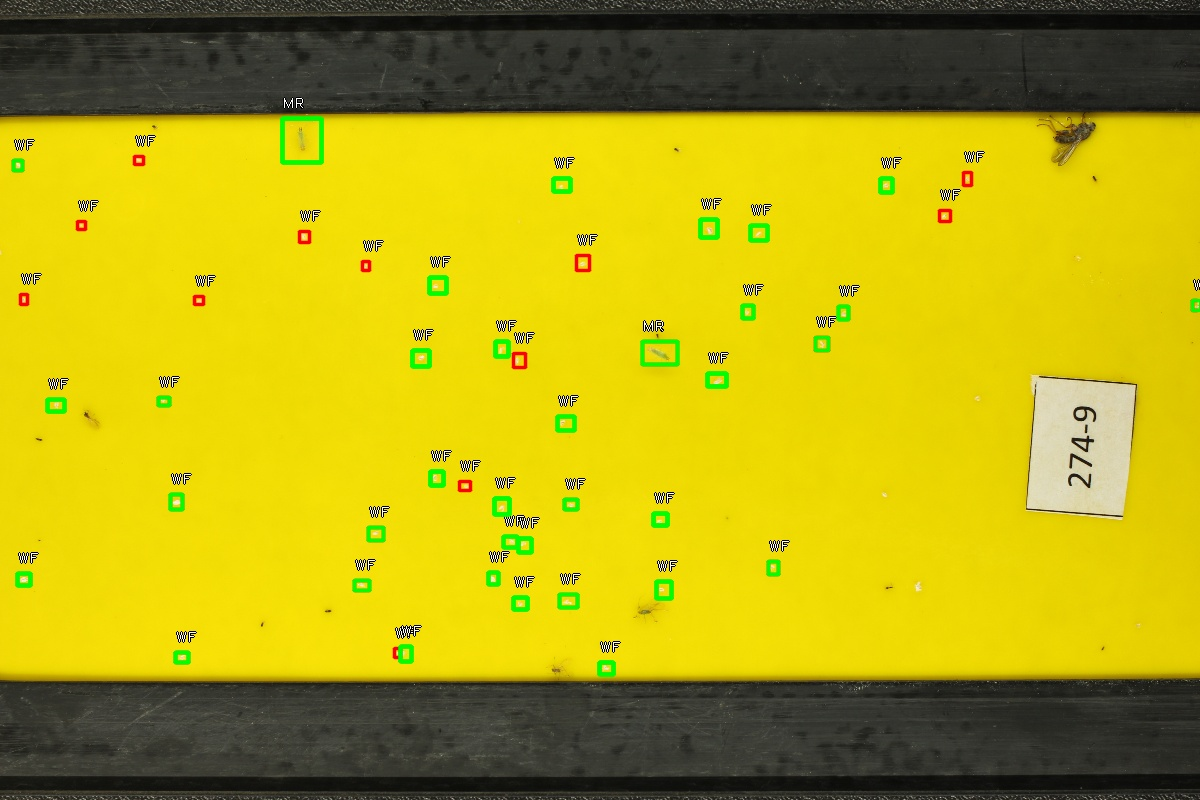

In [ ]:
from IPython.display import Image
Image('1000_optimized.jpg')

In [ ]:
train_generator, validation_generator = create_generators(
    TRAIN_PATH,
    VAL_PATH,
    CLASSES_PATH,
    backbone.preprocess_image,
    config=config)

In [ ]:
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.bin.train import create_callbacks
from argparse import Namespace
from keras_retinanet.utils.anchors import make_shapes_callback

setup_gpu(0)
# Create new model with resnet50 backbone.
backbone = keras_retinanet.models.backbone('resnet50')
model = backbone.retinanet(num_classes=4, modifier=freeze_model)

# Load weights into our new model from pre-trained weights.
if os.path.isfile('resnet50_csv_171.h5'):
  model.load_weights('resnet50_csv_171.h5', by_name=True, skip_mismatch=True)
else:
  model.load_weights('resnet50_coco_best_v2.1.0.h5', by_name=True, skip_mismatch=True)

# make prediction model
prediction_model = retinanet_bbox(model=model, anchor_params=anchor_params)

train_generator.compute_shapes = make_shapes_callback(model)
validation_generator.compute_shapes = train_generator.compute_shapes

filepath="drive/My Drive/model-checkpoint-{epoch:02d}.hdf5"
# Define callback to save model after each epoch (in case Colab decides to crash ...)
args = Namespace(**{'tensorboard_dir': 'tensorboard/',
        'evaluation': True,
        'dataset_type': 'csv',
        'snapshots': True,
        'snapshot_path': 'drive/My Drive/snapshots/',
        'batch_size': 16,
        'weighted_average': True,
        'backbone': 'resnet50'
        })

callbacks = create_callbacks(
    model=model,
    training_model=model,
    prediction_model=prediction_model,
    validation_generator=validation_generator,
    args=args
)

# Compile model.
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001),
    metrics=['accuracy'],
)

tracking <tf.Variable 'Variable_15:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_16:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_17:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_18:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_19:0' shape=(9, 4) dtype=float32> anchors


In [ ]:
history = model.fit_generator(
            generator=train_generator,
            epochs=1,
            verbose=1,
            validation_data=validation_generator,
            callbacks=callbacks,
            initial_epoch=0)



Epoch 1/1
15/15 [==============================] - 153s 10s/step - loss: 2.1653 - regression_loss: 1.7706 - classification_loss: 0.3947 - regression_accuracy: 0.1699 - classification_accuracy: 0.1863 - val_loss: 2.4624 - val_regression_loss: 1.7314 - val_classification_loss: 0.3664 - val_regression_accuracy: 0.1261 - val_classification_accuracy: 0.1745



Running network: 100% (58 of 58) |#######| Elapsed Time: 0:00:54 Time:  0:00:54
Parsing annotations: 100% (58 of 58) |###| Elapsed Time: 0:00:00 Time:  0:00:00


294 instances of class MR with average precision: 0.0784
106 instances of class NC with average precision: 0.2056
787 instances of class WF with average precision: 0.4957
0 instances of class TR with average precision: 0.0000
mAP: 0.3664

Epoch 00001: saving model to drive/My Drive/snapshots/resnet50_csv_01.h5


# Conclusion
We could notice that there is a huge improvement in mAP for the WF class (from 0% to ~50%). However, it did increase for the other classes. The overall mAP is at ~37%.

I believe that these two models could be used disjointly. The first model is good for detecting big insects, the second one is good at detecting small ones. So, in order to be able to detect most insects in the dataset, it's better to use both models.